In [15]:
import sys

sys.path.append("../src")

In [16]:
import importlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt


import lib
import common
importlib.reload(lib)

<module 'lib' from '/Users/r/Documents/stud/ss24/finnpinn/news/../src/lib.py'>

# Reproduced MCMC (Barker Sampler) Results

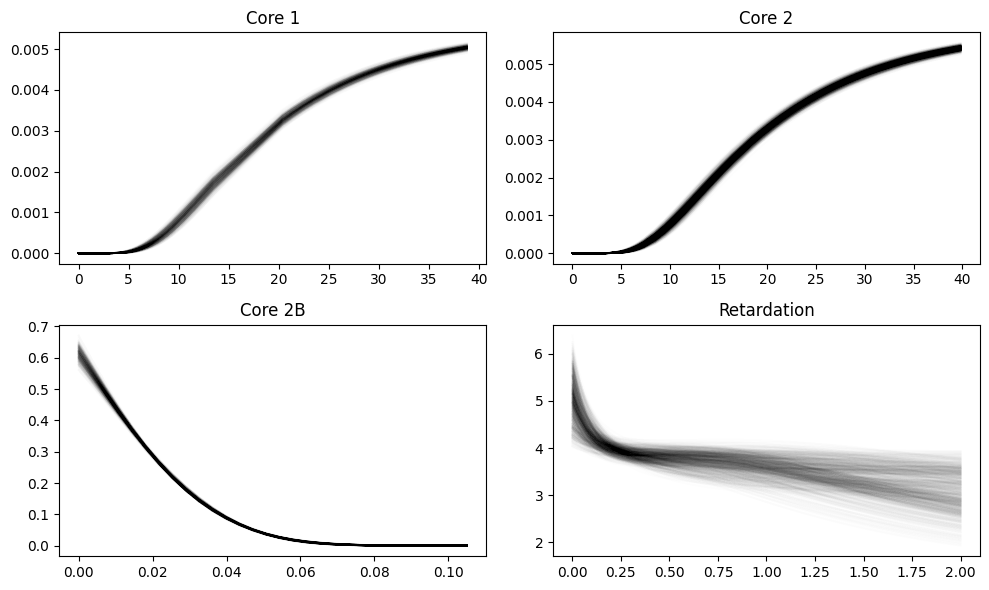

In [17]:
mcmc_samples = lib.ExperimentalSamples.from_dir("../data/mcmc_samples/")
mcmc_samples.plot()

plt.tight_layout()
plt.show()

## Comparison with paper PI

In [18]:
PI_PLOT_KWARGS = dict(
    alpha=0.3,
    edgecolor="none",
    zorder=-10,
)

In [19]:
core2_data = lib.load_exp_data_numpy("Core 2")

In [20]:
upper_my_mcmc_ret_90 = np.quantile(mcmc_samples.ret_y, 0.95, axis=0)
lower_my_mcmc_ret_90 = np.quantile(mcmc_samples.ret_y, 0.05, axis=0)
upper_my_mcmc_core2_90 = np.quantile(mcmc_samples.core2, 0.95, axis=0)
lower_my_mcmc_core2_90 = np.quantile(mcmc_samples.core2, 0.05, axis=0)

In [21]:
_, _, upper_mcmc_PI_core2, lower_mcmc_PI_core2, u_data, _, _, _ = common.load_mcmc_paper_curves(t_eval=core2_data[0])

n_inside_my = np.count_nonzero((core2_data[1] <= upper_my_mcmc_core2_90) & (core2_data[1] >= lower_my_mcmc_core2_90))
n_inside_his = np.count_nonzero((core2_data[1] <= upper_mcmc_PI_core2) & (core2_data[1] >= lower_mcmc_PI_core2))

print(f" My Core 2 PI contains: {n_inside_my/len(core2_data[1]):.1%}")
print(f"His Core 2 PI contains: {n_inside_his/len(core2_data[1]):.1%}")

 My Core 2 PI contains: 49.1%
His Core 2 PI contains: 78.2%


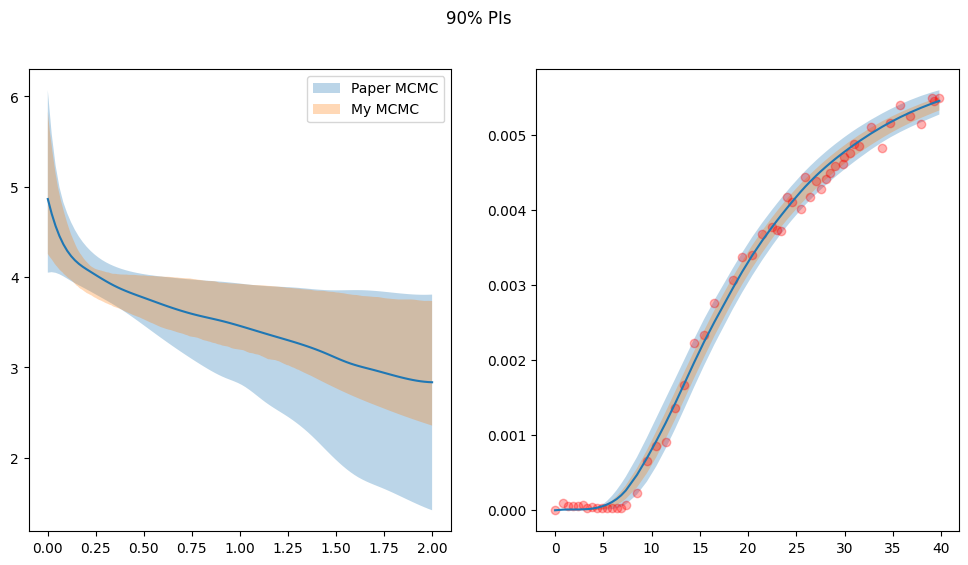

In [22]:
t_eval, mean_core2_paper, upper_mcmc_PI_core2, lower_mcmc_PI_core2, u_eval, mean_ret_core2_paper, upper_ret_mcmc_PI_core2_paper, lower_ret_mcmc_PI_core2_paper = common.load_mcmc_paper_curves(t_eval = lib.load_exp_data_numpy("Core 2")[0])
paper_mcmc_samples = lib.ExperimentalSamples(
    core1 = (None, None),
    core2 = np.array([upper_mcmc_PI_core2, lower_mcmc_PI_core2]),
    core2b = (None, None),
    ret_x=u_eval,
    ret_y=np.array([upper_ret_mcmc_PI_core2_paper, lower_ret_mcmc_PI_core2_paper]),
)

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
fig.suptitle("90% PIs")
axs[0].plot(u_eval, mean_ret_core2_paper, "-", color="C0")
axs[0].fill_between(u_eval, lower_ret_mcmc_PI_core2_paper, upper_ret_mcmc_PI_core2_paper, color="C0", **PI_PLOT_KWARGS, label="Paper MCMC")
axs[0].fill_between(mcmc_samples.ret_x, lower_my_mcmc_ret_90, upper_my_mcmc_ret_90, color="C1", **PI_PLOT_KWARGS, label="My MCMC")
axs[0].legend()

axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[1].plot(t_eval, mean_core2_paper, "-", color="C0")
axs[1].fill_between(t_eval, lower_mcmc_PI_core2, upper_mcmc_PI_core2, color="C0", **PI_PLOT_KWARGS, label="Paper MCMC")
axs[1].fill_between(core2_data[0], lower_my_mcmc_core2_90, upper_my_mcmc_core2_90, color="C1", **PI_PLOT_KWARGS, label="My MCMC")
plt.show()

# SPAN on Core 2 Data

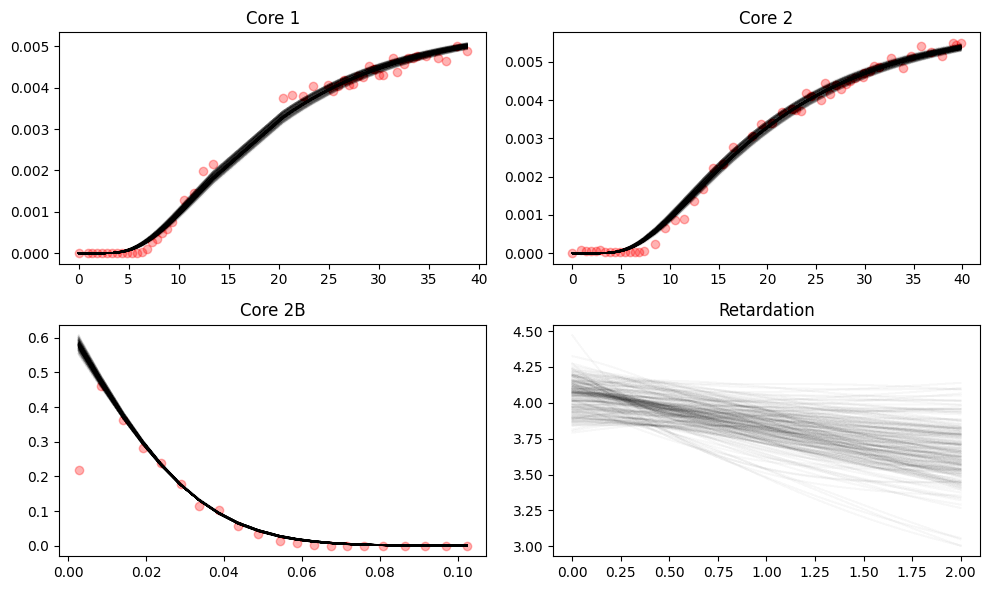

In [33]:
processed_expdata_dir = Path("../data_processed/experimental/SPAN")

span_samples = lib.ExperimentalSamples.from_dir(processed_expdata_dir)
fig, axs = span_samples.plot()

axs[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)

plt.tight_layout()
plt.show()

## P3INN-SPAN (or better name Data-SPAN?)

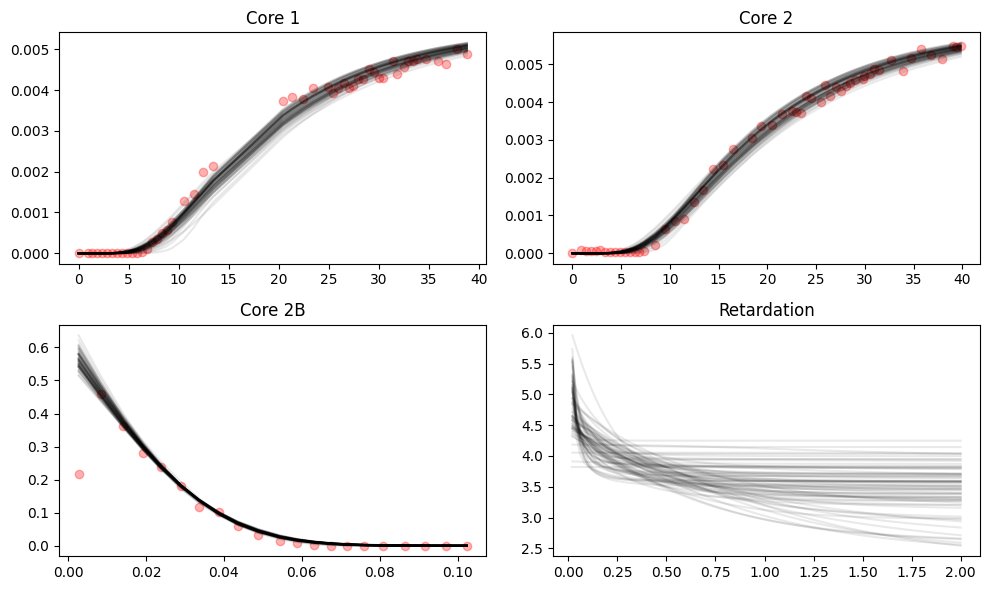

In [34]:
dataspan_samples = lib.ExperimentalSamples.from_dir(Path("../data_processed/experimental/DataSPAN"))
fig, axs = dataspan_samples.plot()

axs[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)

plt.tight_layout()
plt.show()

# Comparisons

In [ ]:
from matplotlib.lines import Line2D

# # Plotting the samples
# mcmc_samples.plot(axs, line_kwargs=dict(alpha=0.2, color="C1"), only_outlines=True)
# span_samples.plot(axs, line_kwargs=dict(alpha=0.2, color="C2"), only_outlines=True)

# # Creating proxy artists for legend
# legend_elements = [
#     Line2D([0], [0], color="C1", label="MCMC Samples"),
#     Line2D([0], [0], color="C2", label="SPAN Samples"),
# ]

# # Adding the legend to the figure (or specify an axis if preferred)
# fig.legend(handles=legend_elements, loc="upper center", ncol=2, fontsize="medium")

# plt.tight_layout()
# plt.show()

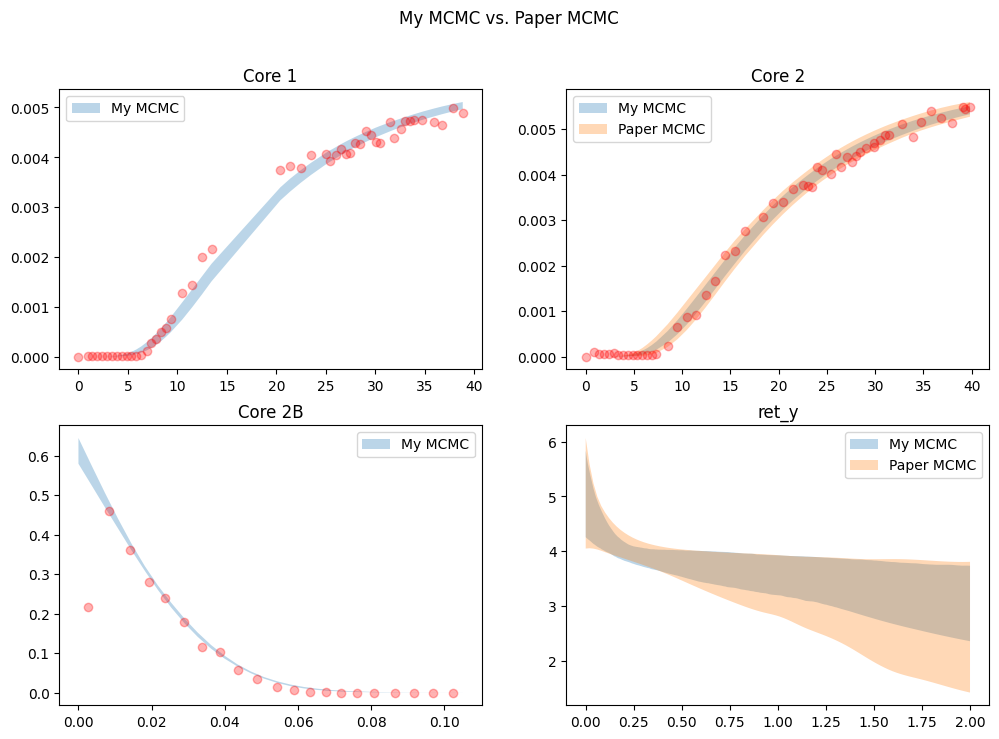

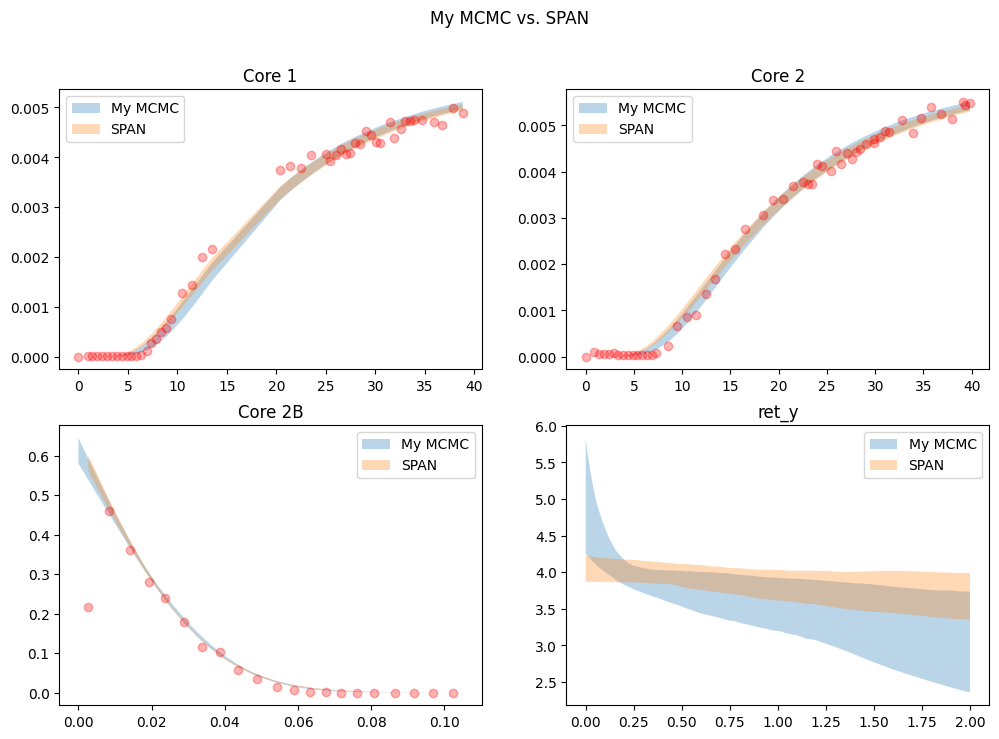

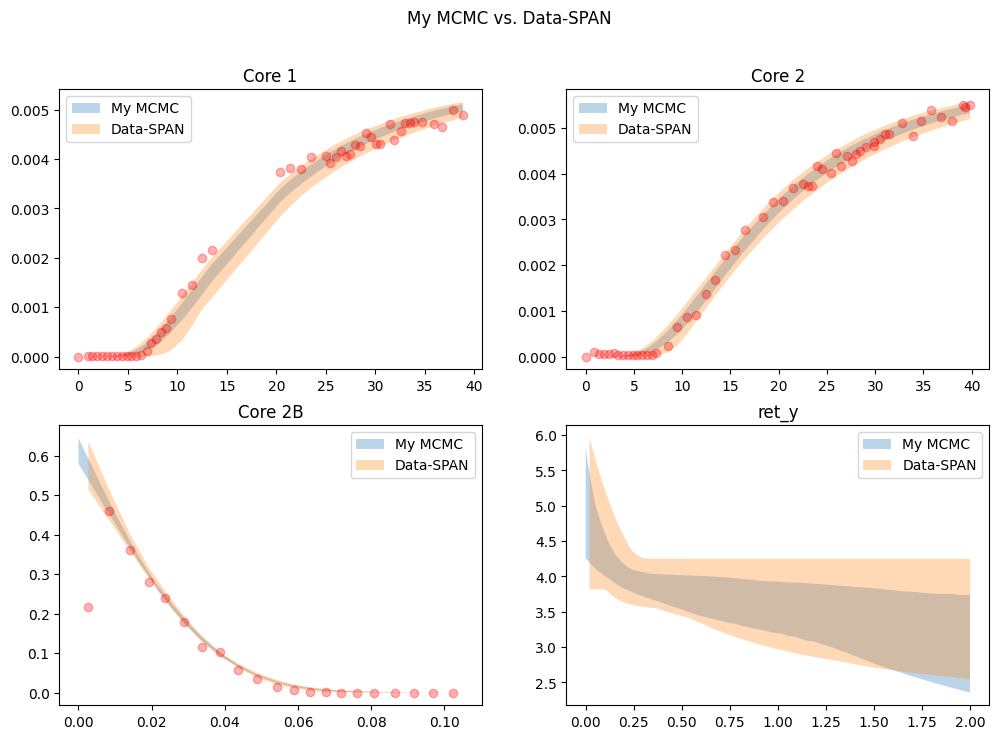

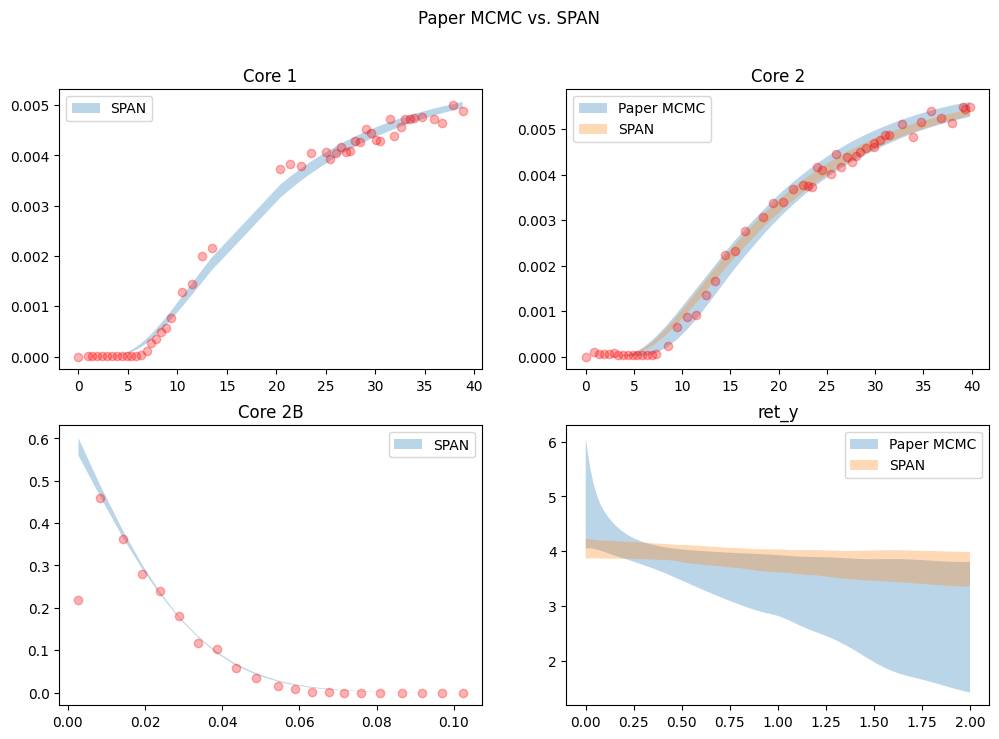

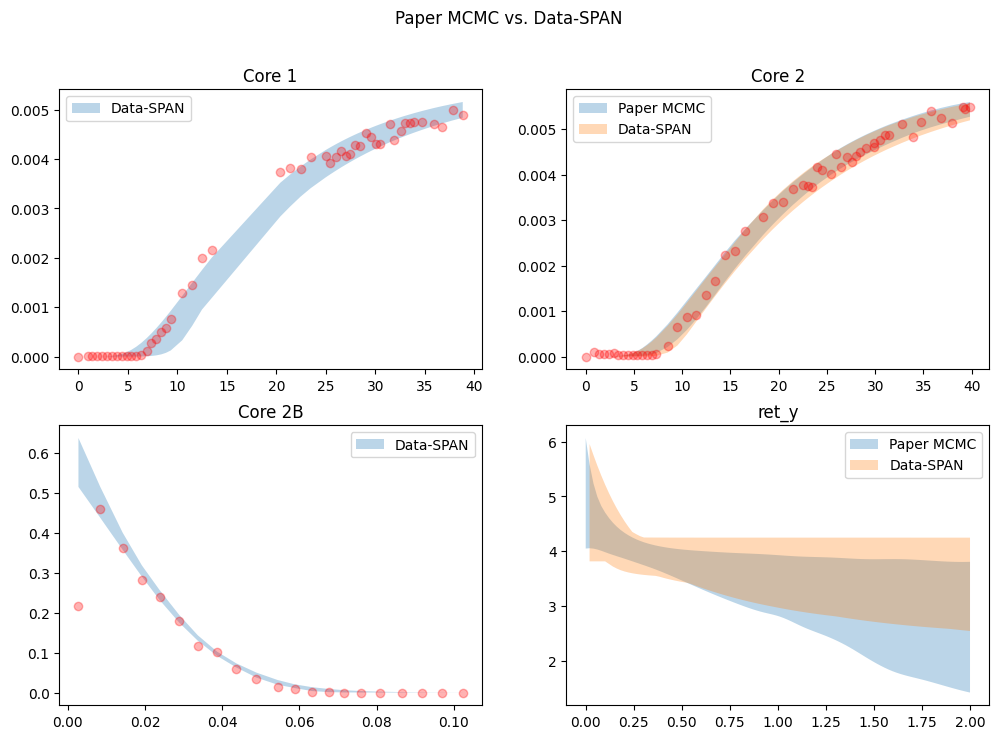

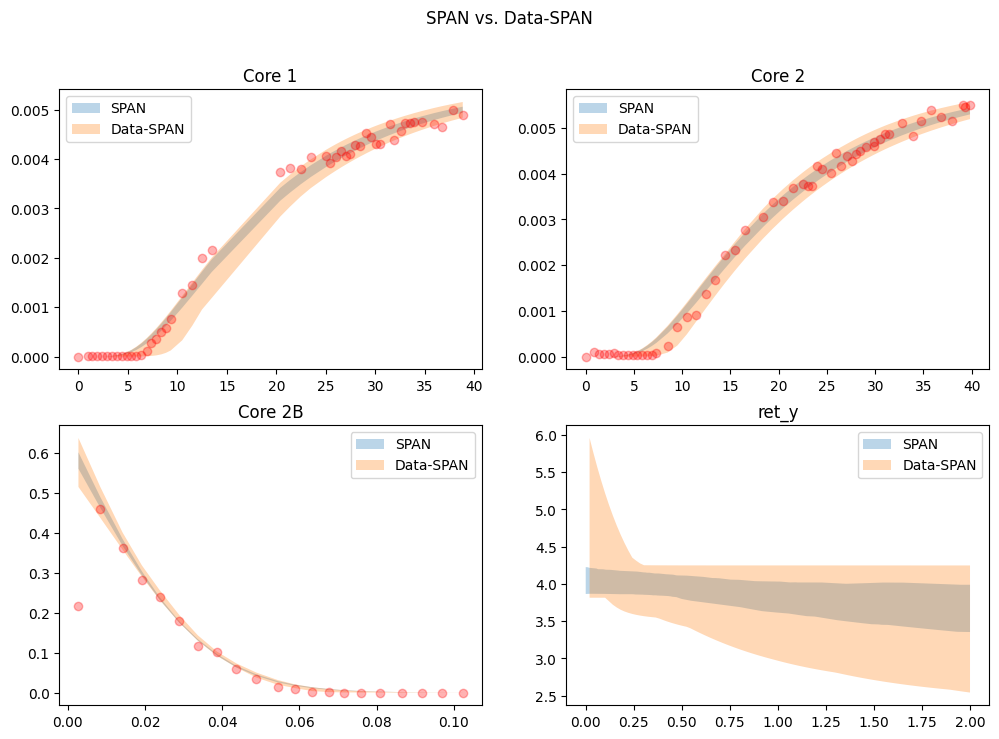

In [42]:
import itertools
from typing import Optional

import matplotlib.pyplot as plt

USED_QUANTILE = 0.9  # Paper says it uses 95%, but the code shows 90%.
assert USED_QUANTILE == 0.9

def upper_lower_from_name(samples, name: str, attr_name: str) -> tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    if name in ["My MCMC", "SPAN"]:
        # These two should in theory cover the whole distribution, thus I compute the quantiles
        upper = np.quantile(getattr(samples, attr_name), (1 + USED_QUANTILE)/2, axis=0)
        lower = np.quantile(getattr(samples, attr_name), (1 - USED_QUANTILE)/2, axis=0)
        # upper = np.max(getattr(samples, attr_name), axis=0)
        # lower = np.min(getattr(samples, attr_name), axis=0)
    elif name == "Paper MCMC":
        upper, lower = getattr(samples, attr_name)
    elif name == "Data-SPAN":
        # I can use envelope here since FINN was trained on 90% and below core 2 quantiles
        upper = np.max(getattr(samples, attr_name), axis=0)
        lower = np.min(getattr(samples, attr_name), axis=0)
    else:
        raise ValueError(f"Unknown method '{name}'")
    return upper, lower


methods = [(mcmc_samples, "My MCMC"), (paper_mcmc_samples, "Paper MCMC"), (span_samples, "SPAN"), (dataspan_samples, "Data-SPAN")]
for method1, method2 in itertools.combinations(methods, 2):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
    fig.suptitle(f"{method1[1]} vs. {method2[1]}")

    axs.flat[0].scatter(*lib.load_exp_data_numpy("Core 1"), color="red", alpha=0.3)
    axs.flat[1].scatter(*core2_data, color="red", alpha=0.3)
    axs.flat[2].scatter(*lib.load_exp_data_numpy("Core 2B"), color="red", alpha=0.3)

    for method in [method1, method2]:
        samples, name = method

        for ax_idx, data_name in enumerate(["Core 1", "Core 2", "Core 2B", "ret_y"]):
            attr_name = data_name.replace(" ", "").lower()
            upper, lower = upper_lower_from_name(samples, name, attr_name)
            if upper is None or lower is None:
                continue

            if attr_name == "ret_y":
                x = samples.ret_x
            elif attr_name == "core2b":
                x = np.linspace(0, lib.load_exp_conf("Core 2B")["X"], int(lib.load_exp_conf("Core 2B")["Nx"]))
                if x.shape[0] != lower.shape[0]:
                    x = lib.load_exp_data_numpy("Core 2B")[0]
            else:
                x = lib.load_exp_data_numpy(data_name)[0]
            # print(x.shape, lower.shape, upper.shape, attr_name, name)
            axs.flat[ax_idx].fill_between(x, lower, upper, **PI_PLOT_KWARGS, label=f"{name}")
            axs.flat[ax_idx].set_title(f"{data_name}")
            axs.flat[ax_idx].legend()
